In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from evolution.candidate import Candidate
from evolution.evaluation.evaluator import Evaluator
from generate_url import open_browser

In [2]:
results_dir = Path("results/zerocarbon/basetwo")
config = json.load(open(results_dir / "config.json"))
gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes)

100 {'CO2 Equivalent Net Emissions': True, 'Adjusted cost of energy per GJ': True}


In [3]:
model_params = config["model_params"]
input_specs = pd.read_json("inputSpecs.jsonl", lines=True, precise_float=True)
model_params["in_size"] = len(context) if len(context) > 0 else len(input_specs) - len(actions)
model_params["out_size"] = len(actions)

evaluator = Evaluator("experiments/temp", context, actions, outcomes)

Generating new zero carbon breakthrough context...
make: `enroads' is up to date.


In [4]:
baseline_actions = {}
baseline_df = evaluator.evaluate_actions(baseline_actions)
outcome_keys = list(outcomes.keys())
enroads_outcomes = [key for key in outcome_keys if key not in ["Cost of energy next 10 years", "Average Energy Change"]]
enroads_outcomes = list(set(enroads_outcomes + ["CO2 Equivalent Net Emissions", "Adjusted cost of energy per GJ"]))
baseline_metrics = evaluator.process_outcomes(baseline_df)
for outcome in outcomes:
    print(f"{outcome}: {baseline_metrics[outcome]}")

CO2 Equivalent Net Emissions: 71.7844
Adjusted cost of energy per GJ: 19.5638


In [5]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,rank,distance,CO2 Equivalent Net Emissions,Adjusted cost of energy per GJ
0,100_22,"['99_14', '99_23']",1,inf,24.582400,13.357777
1,100_65,"['99_11', '99_73']",1,inf,24.036000,13.430337
2,100_57,"['98_58', '99_11']",1,1.281390,24.206333,13.403327
3,100_56,"['99_14', '98_34']",1,1.021921,24.495633,13.398397
4,100_84,"['99_32', '99_14']",1,0.564537,24.526000,13.371627
5,100_2,"['99_26', '98_34']",1,0.294098,24.571133,13.367460


In [6]:
def get_spaced_elements(array, numElems = 4):
    out = np.array(array)[np.round(np.linspace(0, len(array)-1, numElems)).astype(int)]
    return out

In [7]:
sample_points = get_spaced_elements(final_pareto.sort_values("CO2 Equivalent Net Emissions")["cand_id"].tolist(), 8)

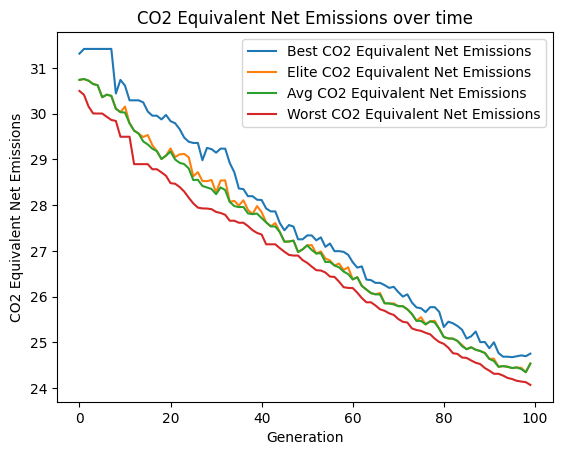

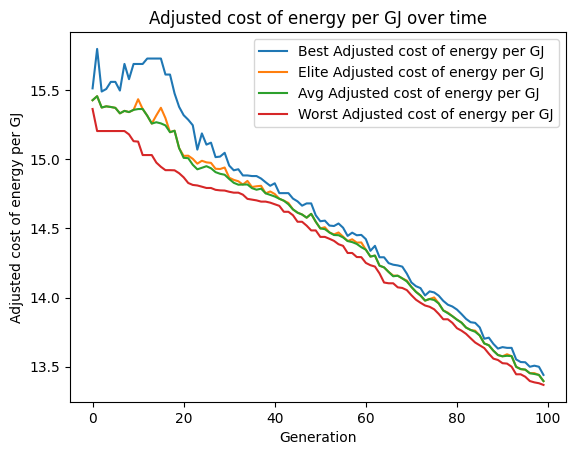

In [8]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(gens):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto[(pareto[outcome] != float("inf")) & (pareto[outcome] != -float("inf"))][outcome]
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.nlargest(n_elites).mean())
    
    # plt.plot(range(gens), [baseline_df[outcome].iloc[-1] for _ in range(gens)], label=f"Baseline {outcome}", color="black")

    plt.plot(range(gens), best, label=f"Best {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Worst {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

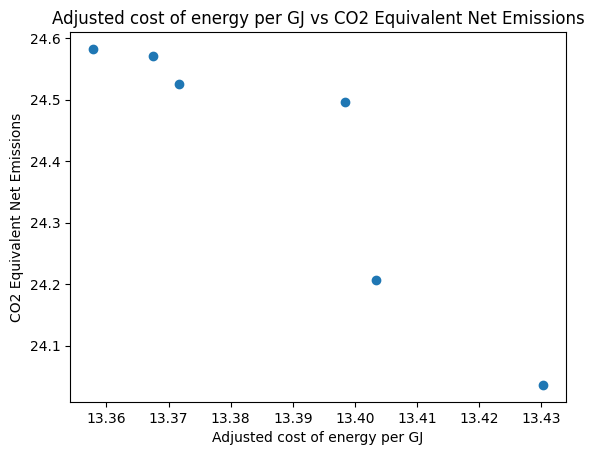

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_18226/222920776.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


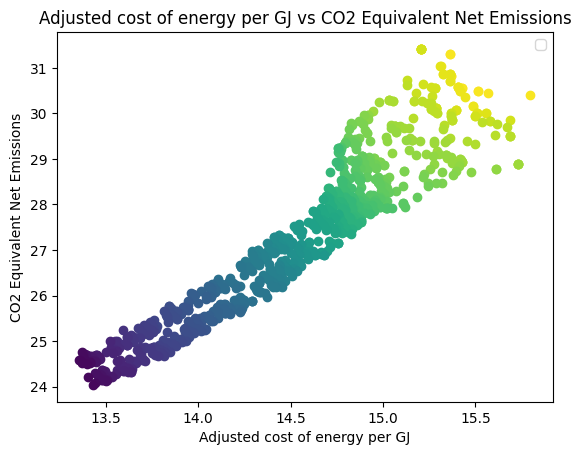

In [9]:
def plot_two_objective(outcome1, outcome2, gens, pareto=True):
    if len(gens) == 1:
        colors = ["C0"]
    else:
        colors = plt.cm.viridis_r([i / (len(gens)+1) for i in range(len(gens)+1)])
    for gen in gens:
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        gen_df = gen_df[gen_df["rank"] == 1] if pareto else gen_df
        gen_df = gen_df[(gen_df[outcome1] != float("inf")) & (gen_df[outcome1] != -float("inf"))]
        plt.scatter(gen_df[outcome1], gen_df[outcome2], color=colors[gens.index(gen)])

    # plt.scatter(baseline_df[outcome1].iloc[-1], baseline_df[outcome2].iloc[-1], color="black", label="Baseline")
    if len(gens) != 1:
        plt.legend()
    plt.title(f"{outcome1} vs {outcome2}")
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_two_objective(outcome_keys[1], outcome_keys[0], [gens])
plot_two_objective(outcome_keys[1], outcome_keys[0], range(gens+1))
#plot_two_objective(outcome_keys[1], outcome_keys[2], [gens])
# plot_two_objective(outcome_keys[0], outcome_keys[2], [gens])
# plot_two_objective(outcome_keys[2], outcome_keys[3], range(gens+1))
# plot_two_objective(outcomes[1], outcomes[0], [1, 25, 50, 100])
# plot_two_objective(outcomes[2], outcomes[1], range(gens+1))
# plot_two_objective(outcomes[2], outcomes[0], range(gens+1))

In [10]:
def get_candidate_actions(candidate: Candidate, torch_context: torch.Tensor, context_vals: torch.Tensor):
    [actions_dict] = candidate.prescribe(torch_context.to("mps").unsqueeze(0))
    context_dict = dict(zip(context, context_vals.tolist()))
    actions_dict.update(context_dict)
    return actions_dict

def get_candidate_from_id(results_dir: Path, cand_id: str):
    cand_path = results_dir / cand_id.split("_")[0] / f"{cand_id}.pt"
    return Candidate.from_seed(cand_path, model_params, actions, outcomes)

In [11]:
best_cand_ids = []
for outcome, ascending in outcomes.items():
    best_cand_ids.append(final_pareto.sort_values(outcome, ascending=ascending).iloc[0]["cand_id"])
    print(final_pareto.sort_values(outcome, ascending=ascending).iloc[0][outcome_keys])
    print()
best_cand_ids = list(set(best_cand_ids))
best_cand_ids

CO2 Equivalent Net Emissions         24.036
Adjusted cost of energy per GJ    13.430337
Name: 1, dtype: object

CO2 Equivalent Net Emissions        24.5824
Adjusted cost of energy per GJ    13.357777
Name: 0, dtype: object



['100_65', '100_22']

In [12]:
def visualize_action_differences(cand_id1, cand_id2, context_input, context_vals):
    cand1 = get_candidate_from_id(results_dir, cand_id1)
    cand2 = get_candidate_from_id(results_dir, cand_id2)
    cand1_actions = get_candidate_actions(cand1, context_input, context_vals)
    cand2_actions = get_candidate_actions(cand2, context_input, context_vals)
    input_specs = pd.read_json("inputSpecs.jsonl", lines=True, precise_float=True)

    fig, ax = plt.subplots(figsize=(5, 10))
    annotations = []
    labels = []
    y_positions = []
    for i, act in enumerate(actions):
        cand1_val = cand1_actions[act]
        cand2_val = cand2_actions[act]
        row = input_specs[input_specs["varId"] == act]
        y_positions.append(i)
        labels.append(input_specs[input_specs["varId"] == act]["varName"].iloc[0])
        if row["kind"].iloc[0] == "slider":
            min_val = input_specs[input_specs["varId"] == act]["minValue"].iloc[0]
            max_val = input_specs[input_specs["varId"] == act]["maxValue"].iloc[0]
            normalized1 = (cand1_val - min_val) / (max_val - min_val)
            normalized2 = (cand2_val - min_val) / (max_val - min_val)
            ax.scatter([normalized1 - normalized2], [i])
            # ax.annotate(f"{cand1_val:.2f} - {cand2_val:.2f}", (normalized1 - normalized2, i))
            annotations.append(f"{cand1_val:.2f} - {cand2_val:.2f}")
        else:
            assert cand1_val == 0 or cand1_val == 1
            assert cand2_val == 0 or cand2_val == 1
            ax.scatter([cand1_val - cand2_val], [i])
            # ax.annotate(f"{cand1_val} - {cand2_val}", (cand1_val - cand2_val, i))
            annotations.append(f"{cand1_val} - {cand2_val}")

    assert len(annotations) == len(labels)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    plt.axvline(0, color="black")
    plt.title(f"{cand_id1} vs. {cand_id2}")
    ax.set_xticks(range(-1, 1))
    plt.ylabel("Action")
    plt.xlabel("Minmax Normalized Value")
    plt.grid(axis="y")
    # plt.tight_layout()
    plt.show()

In [13]:
def visualize_difference_base(results_dirs, cand_ids, context_input, context_vals):
    fig, ax = plt.subplots(figsize=(5, 10))
    for results_dir, cand_id, color in zip(results_dirs, cand_ids, plt.rcParams['axes.prop_cycle'].by_key()['color']):
        cand = get_candidate_from_id(results_dir, cand_id)
        cand_actions = get_candidate_actions(cand, context_input, context_vals)
        input_specs = pd.read_json("inputSpecs.jsonl", lines=True, precise_float=True)
        i = 0
        for act, val in cand_actions.items():
            row = input_specs[input_specs["varId"] == act]
            baseline_val = row["defaultValue"].iloc[0]
            if row["kind"].iloc[0] == "slider":
                min_val = input_specs[input_specs["varId"] == act]["minValue"].iloc[0]
                max_val = input_specs[input_specs["varId"] == act]["maxValue"].iloc[0]
                assert val >= min_val and val <= max_val
                normalized_y = (val - min_val) / (max_val - min_val)
                normalized_baseline = (baseline_val - min_val) / (max_val - min_val)
                ax.scatter([normalized_y - normalized_baseline], [i], color=color)
                ax.annotate(f"{val:.2f}", (normalized_y - normalized_baseline, i))
            else:
                assert val == 0 or val == 1
                ax.scatter([val - baseline_val], [i], color=color)
                ax.annotate("on" if val == 1 else "off", (val-baseline_val, i))
            
            i += 1

    plt.axvline(0, color="black", linestyle="--")
    ax.set_yticks(range(len(cand_actions)))
    labels = [input_specs[input_specs["varId"] == act]["varName"].iloc[0] for act in cand_actions.keys()]
    ax.set_yticklabels(labels)
    plt.title(f"Actions for Candidates {cand_ids}")
    plt.ylabel("Action")
    plt.xlabel("Difference from Baseline Normalized")
    plt.grid(axis="y")
    plt.show()


In [14]:
context_input, context_vals = evaluator.context_dataset[1]
# print(context_vals, context_input)
#visualize_difference_base([results_dir], [best_cand_ids[0]], context_input, context_vals)

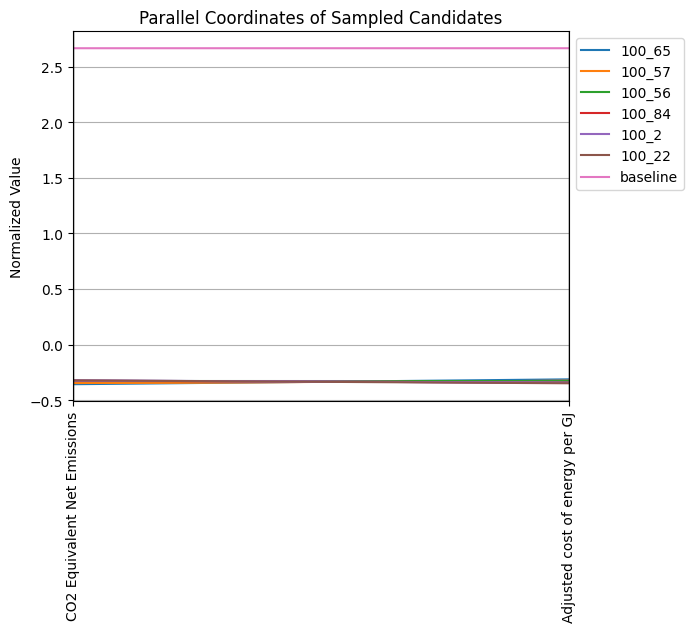

In [15]:
def plot_parallel_coordinates(cand_ids):
    coords_dicts = []
    for cand_id in cand_ids:
        gen = int(cand_id.split("_")[0])
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        row = gen_df[gen_df["cand_id"] == cand_id].iloc[0]
        cand_coords = [row[outcome] for outcome in outcomes]
        cand_dict = dict(zip(outcomes.keys(), cand_coords))
        cand_dict["cand_id"] = cand_id
        coords_dicts.append(cand_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / normalized_df.std()
    normalized_df["cand_id"] = coords_df["cand_id"]
    
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    colors[len(coords_df)-1] = "black" 
    pd.plotting.parallel_coordinates(normalized_df, "cand_id", color=colors)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")

plot_parallel_coordinates(sample_points)

In [16]:
def get_average_df(dfs: list[pd.DataFrame]):
    avg_df = dfs[0].copy()
    for df in dfs[1:]:
        avg_df += df
    avg_df /= len(dfs)
    return avg_df

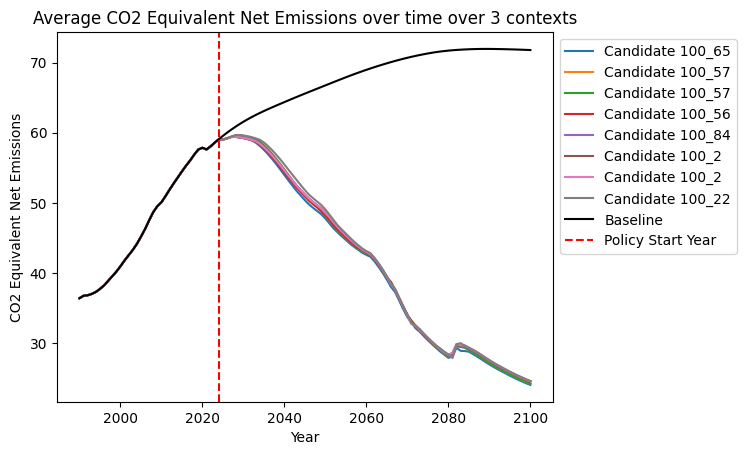

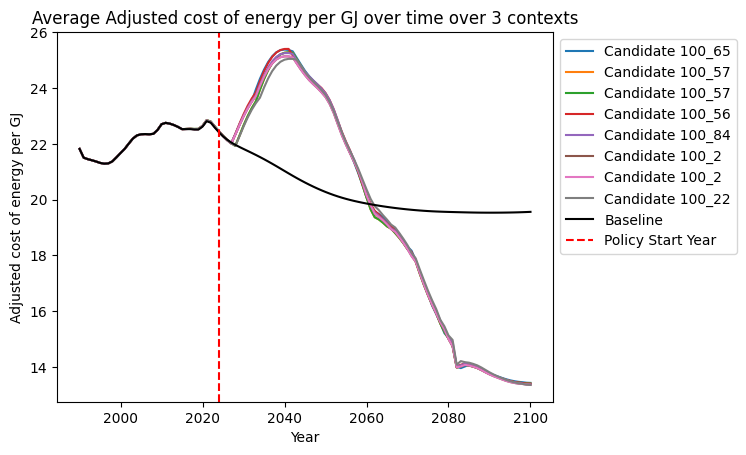

In [17]:
def plot_outcome_over_time(outcome, cand_ids):
    for cand_id in cand_ids:
        cand = get_candidate_from_id(results_dir, cand_id)
        cand_outcomes = evaluator.evaluate_candidate(cand)
        avg_df = get_average_df(cand_outcomes)
        plt.plot(range(1990, 2101), avg_df[outcome], label=f"Candidate {cand_id}")
    plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
    plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")
    plt.legend(bbox_to_anchor=(1, 1))
    if len(cand_outcomes) > 1:
        plt.title(f"Average {outcome} over time over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"{outcome} over time")
    plt.xlabel("Year")
    plt.ylabel(outcome)
    plt.show()


for outcome in enroads_outcomes:
    plot_outcome_over_time(outcome, sample_points)

In [18]:
def plot_energy_usage(cand_ids):
    fig, axes = plt.subplots(1, len(cand_ids), sharey=True, figsize=(15, 5))
    if len(cand_ids) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_ids, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            cand = get_candidate_from_id(results_dir, cand_id)
            outcomes = evaluator.evaluate_candidate(cand)
            cand_outcomes = get_average_df(outcomes)
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [f"Primary energy demand of {energy}" for energy in energies]
        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for Candidate {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    plt.show()

In [19]:
def plot_energy_difference(cand_id):
    colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
    energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
    demands = [f"Primary energy demand of {energy}" for energy in energies]

    cand = get_candidate_from_id(results_dir, cand_id)
    cand_outcomes = evaluator.evaluate_candidate(cand)
    avg_outcomes = get_average_df(cand_outcomes)
    energy_df = avg_outcomes[demands]

    energy_baseline = baseline_df[demands]

    diff_df = energy_df - energy_baseline
    plt.grid(axis="y")
    plt.bar(energies, diff_df.iloc[-1], color=colors)
    plt.ylabel("Difference in Energy (Exajoules / year)")
    plt.xlabel("Energy Source")
    if len(cand_outcomes) > 1:
        plt.title(f"Average Difference in Energy from Baseline for {cand_id} in 2100 over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"Difference in Energy from Baseline for {cand_id} in 2100")
    plt.xticks(rotation=90)
    plt.show()

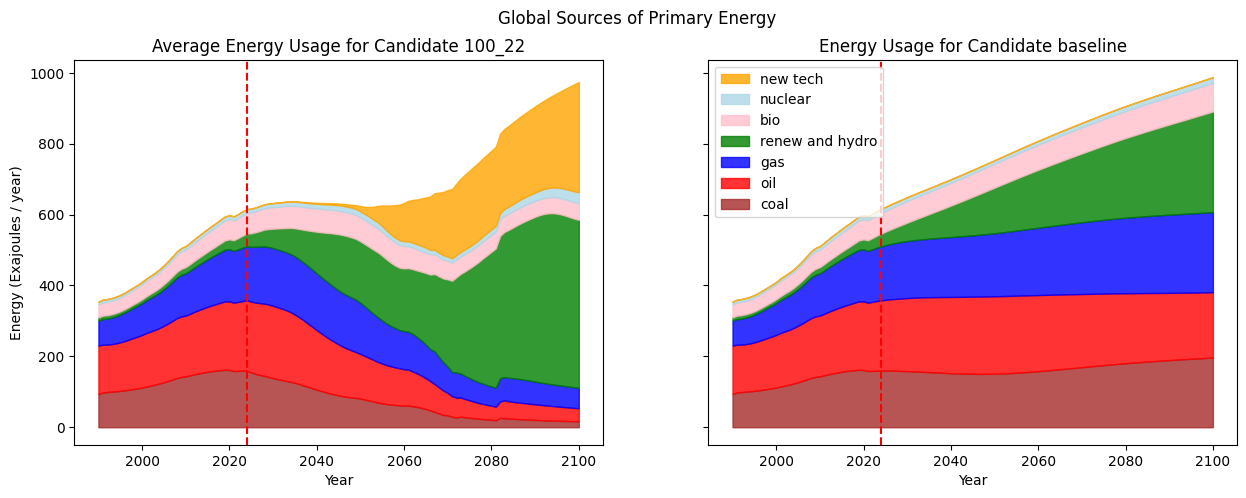

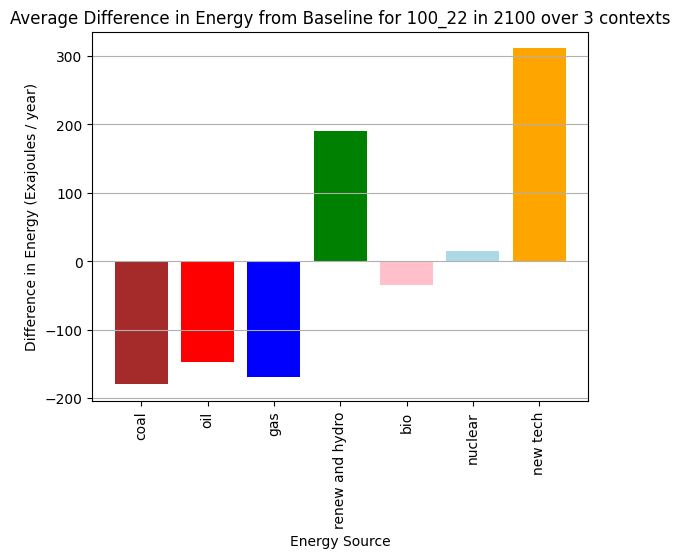

In [24]:
example = "100_22"
plot_energy_usage([example, "baseline"])
plot_energy_difference(example)

In [25]:
open_browser(results_dir, example, input_idx=0)
open_browser(results_dir, example, input_idx=1)
open_browser(results_dir, example, input_idx=2)

Generating new zero carbon breakthrough context...
make: `enroads' is up to date.
Generating new zero carbon breakthrough context...
make: `enroads' is up to date.
Generating new zero carbon breakthrough context...
make: `enroads' is up to date.
